In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np 
import pandas as pd

import gc
import glob
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, InputLayer
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.backend import clear_session
import tensorflow as tf

import cv2
import os
from tqdm import tqdm

import time

from os import listdir
import csv

%matplotlib inline

In [2]:
input_size = 128
epochs = 10
dropout_rate = 0.5
batch_size = 128
shape = (input_size, input_size, 3)
path = '/kaggle/input/planets-dataset/planet/planet/'
train_path = '/kaggle/input/planets-dataset/planet/planet/train-jpg'
test_path = '/kaggle/input/planets-dataset/planet/planet/test-jpg'
lr = 0.0001
reg_str = 0.01 # Regularization Strength
nfolds = 2 # No of folds for cross validation
workers = 4 # Multithreading no of threads
maxq = 10 # Max Queue size for multithreading
tresh = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.

In [3]:
df_train = pd.read_csv(f'{path}train_classes.csv')
df_test = pd.read_csv(f'{path}sample_submission.csv')

df_train['image_name'] = df_train['image_name'].astype(str) + '.jpg'
df_test['image_name'] = df_test['image_name'].astype(str) + '.jpg'

df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

print(df_train.head())
print(df_test.head())

X_train_files = np.array(df_train['image_name'].tolist())
X_train_files.reshape((X_train_files.shape[0], 1))

y_train = np.array(df_train['tags'].tolist())

    image_name                                       tags
0  train_0.jpg                               haze primary
1  train_1.jpg            agriculture clear primary water
2  train_2.jpg                              clear primary
3  train_3.jpg                              clear primary
4  train_4.jpg  agriculture clear habitation primary road
   image_name                                        tags
0  test_0.jpg  [primary, clear, agriculture, road, water]
1  test_1.jpg  [primary, clear, agriculture, road, water]
2  test_2.jpg  [primary, clear, agriculture, road, water]
3  test_3.jpg  [primary, clear, agriculture, road, water]
4  test_4.jpg  [primary, clear, agriculture, road, water]


In [4]:
labels = []

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label not in labels:
            labels.append(label)
        
labels.sort()
print(labels)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


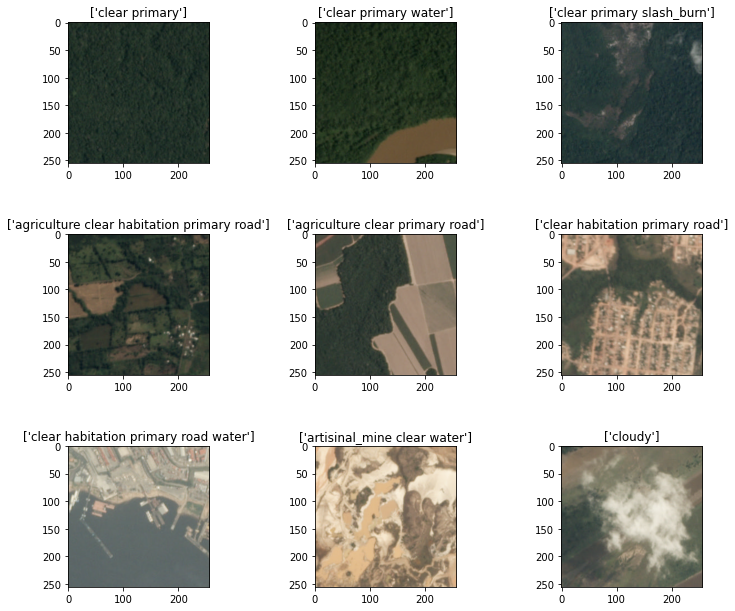

In [5]:
# viewing 9 different images
image_paths = []

all_image_paths_jpg = sorted(glob.glob('../input/planets-dataset/planet/planet/train-jpg/*.jpg'))
nine_imgs_paths_jpg = []
nine_imgs_paths_jpg.append(all_image_paths_jpg[11006])
nine_imgs_paths_jpg.append(all_image_paths_jpg[15000])
nine_imgs_paths_jpg.append(all_image_paths_jpg[4005])
nine_imgs_paths_jpg.append(all_image_paths_jpg[12007])
nine_imgs_paths_jpg.append(all_image_paths_jpg[8002])
nine_imgs_paths_jpg.append(all_image_paths_jpg[14001])
nine_imgs_paths_jpg.append(all_image_paths_jpg[16004])
nine_imgs_paths_jpg.append(all_image_paths_jpg[13003])
nine_imgs_paths_jpg.append(all_image_paths_jpg[9006])

nine_image_names = list(map(lambda row: row.split("/")[-1][:-4], nine_imgs_paths_jpg))
labels_df = pd.read_csv(f'{path}train_classes.csv')

# Plot them in a 3 by 3 grid
plt.figure(figsize=(12,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
    plt.imshow(plt.imread(nine_imgs_paths_jpg[i]))
    plt.title(str(labels_df[labels_df.image_name == nine_image_names[i]].tags.values))

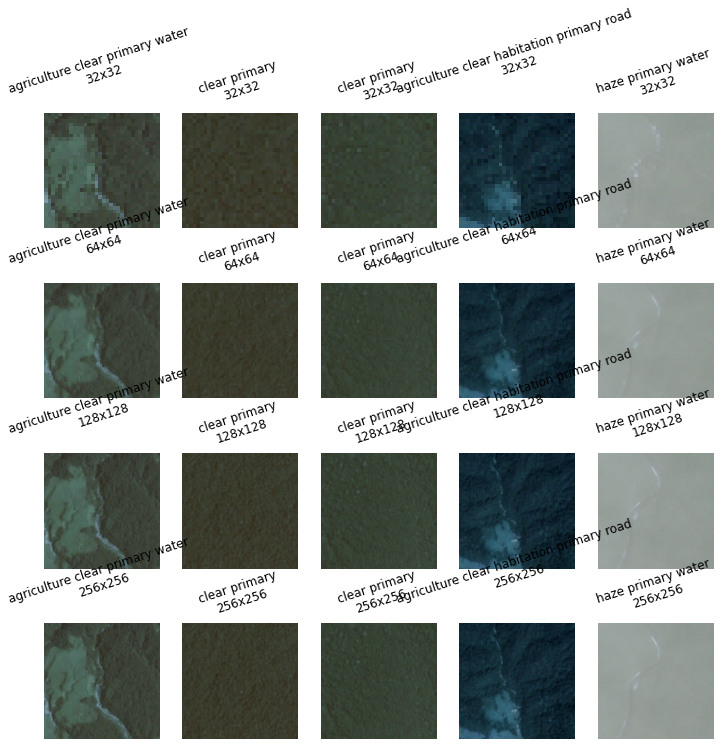

In [6]:
# using open cv to view some images
plt.figure(figsize=(12, 12))
res = [32, 64, 128, 256]
NIMGS = 5

for i in range(len(res)):
    for j in range(NIMGS):
        img = cv2.imread(os.path.join(train_path,df_train['image_name'][j+1]))
        img = cv2.resize(img, (res[i], res[i]))
        plt.subplot(len(res), NIMGS, i*NIMGS+j+1)
        plt.imshow(img)
        plt.title(df_train['tags'][j+1] + "\n" + str(res[i]) + "x" + str(res[i]), rotation=18)
        plt.axis('off')
    
plt.show()

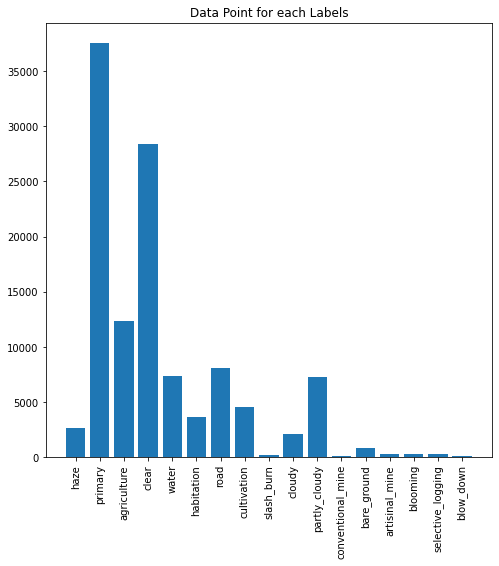

In [7]:
plt.figure(figsize=(8, 8))

labels_count = {}

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label in labels_count:
            labels_count[label] += 1
        else:
            labels_count[label] = 0
            
min_label = min(labels_count, key=labels_count.get)
max_label = max(labels_count, key=labels_count.get)

plt.bar(range(len(labels_count)), list(labels_count.values()), align='center')
plt.xticks(range(len(labels_count)), list(labels_count.keys()), rotation=90)
plt.title('Data Point for each Labels')

plt.show()

In [8]:
# defining model used

def create_model():
    model = Sequential()
    model.add(InputLayer(shape))
    model.add(VGG16(weights='imagenet', include_top=False))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(17, activation='sigmoid'))
    return model

clear_session()

model = create_model()
model.summary()

2021-10-22 06:22:40.403972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 06:22:40.487654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 06:22:40.488389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 06:22:40.489444: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              33558528  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________

In [9]:
# defining metrics used

def f2_score(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 5 * precision * recall / (4 * precision + recall)
    f_score = tf.where(tf.math.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)

In [10]:
# using the Model on the train and validation data
num_fold = 0

y_test = []
y_test2 = []

folds = KFold(n_splits=nfolds, shuffle=True, random_state=1).split(X_train_files, y_train)

for train_index, val_index in folds:
    X_train_files_fold = X_train_files[train_index]
    y_train_fold = y_train[train_index]
    X_val_files_fold = X_train_files[val_index]
    y_val_fold = np.array(y_train[val_index])
    
    train_df = pd.DataFrame(list(zip(X_train_files_fold, y_train_fold)), columns = ['image_name', 'tags'])
    val_df = pd.DataFrame(list(zip(X_val_files_fold, y_val_fold)), columns = ['image_name', 'tags'])
    
    train_df['tags'] = train_df['tags'].apply(lambda x: x.split(' '))
    val_df['tags'] = val_df['tags'].apply(lambda x: x.split(' '))

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=train_path,
        x_col='image_name',
        y_col='tags',
        target_size=(shape[0], shape[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
    )
    
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=train_path,
        x_col='image_name',
        y_col='tags',
        target_size=(shape[0], shape[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
    )
    
    test_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        df_test,
        directory=test_path,
        x_col='image_name',
        y_col='tags',
        target_size=(shape[0], shape[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
        shuffle=False,
    )
    
    test_datagen2 = ImageDataGenerator(
        rescale=1./255
    )
    
    test_generator2 = test_datagen2.flow_from_dataframe(
        df_test,
        directory="../input/planets-dataset/test-jpg-additional/test-jpg-additional",
        x_col='image_name',
        y_col='tags',
        target_size=(shape[0], shape[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
        shuffle=False,
    )


    model_path_of_fold = os.path.join('', 'weights_of_fold_' + str(num_fold) + '.h5')
    
    clear_session()
    model = create_model()
    
    adam = Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f2_score])
    
    callbacks = [
        ModelCheckpoint(model_path_of_fold, monitor='val_f2_score', save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
    ]
    
    model.fit_generator(train_generator, epochs=epochs, validation_data=val_generator, callbacks=callbacks,
                       workers=workers, use_multiprocessing=True, max_queue_size=maxq)

    model.load_weights(model_path_of_fold)

    p_test = model.predict_generator(test_generator, workers=workers, use_multiprocessing=True, max_queue_size=maxq)
    y_test.append(p_test)
    
    p_test2 = model.predict_generator(test_generator2, workers=workers, use_multiprocessing=True, max_queue_size=maxq)
    y_test2.append(p_test2)
    

Found 20239 validated image filenames belonging to 17 classes.
Found 20240 validated image filenames belonging to 17 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 20522 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 40669 validated image filenames belonging to 17 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 40669 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 20522 validated image filenames belonging to 17 classes.


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-10-22 06:26:34.520255: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-10-22 06:26:39.891558: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


159/159 [==============================] - 213s 1s/step - loss: 0.2066 - f2_score: 0.7127 - val_loss: 0.1500 - val_f2_score: 0.8271
Epoch 2/10
159/159 [==============================] - 159s 984ms/step - loss: 0.1497 - f2_score: 0.8119 - val_loss: 0.1367 - val_f2_score: 0.8455
Epoch 3/10
159/159 [==============================] - 191s 1s/step - loss: 0.1299 - f2_score: 0.8463 - val_loss: 0.1183 - val_f2_score: 0.8791
Epoch 4/10
159/159 [==============================] - 190s 1s/step - loss: 0.1234 - f2_score: 0.8577 - val_loss: 0.1086 - val_f2_score: 0.8840
Epoch 5/10
159/159 [==============================] - 163s 1s/step - loss: 0.1173 - f2_score: 0.8655 - val_loss: 0.1139 - val_f2_score: 0.8952
Epoch 6/10
159/159 [==============================] - 192s 1s/step - loss: 0.1127 - f2_score: 0.8717 - val_loss: 0.1098 - val_f2_score: 0.8910
Epoch 7/10
159/159 [==============================] - 159s 986ms/step - loss: 0.1099 - f2_score: 0.8751 - val_loss: 0.1049 - val_f2_score: 0.8877
Epoc

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Found 20240 validated image filenames belonging to 17 classes.
Found 20239 validated image filenames belonging to 17 classes.
Found 40669 validated image filenames belonging to 17 classes.
Found 20522 validated image filenames belonging to 17 classes.
Epoch 1/10
159/159 [==============================] - 165s 1s/step - loss: 0.2112 - f2_score: 0.7054 - val_loss: 0.1543 - val_f2_score: 0.8013
Epoch 2/10
159/159 [==============================] - 162s 1s/step - loss: 0.1531 - f2_score: 0.8015 - val_loss: 0.1528 - val_f2_score: 0.8402
Epoch 3/10
159/159 [==============================] - 162s 1s/step - loss: 0.1401 - f2_score: 0.8250 - val_loss: 0.1297 - val_f2_score: 0.8414
Epoch 4/10
159/159 [==============================] - 160s 995ms/step - loss: 0.1289 - f2_score: 0.8446 - val_loss: 0.1215 - val_f2_score: 0.8763
Epoch 5/10
159/159 [==============================] - 160s 987ms/step - loss: 0.1225 - f2_score: 0.8566 - val_loss: 0.1157 - val_f2_score: 0.8834
Epoch 6/10
159/159 [=======

# Making preparation for submission

In [11]:
result1 = np.array(y_test[0])
for i in range(1, nfolds):
    result1 += np.array(y_test[i])
result1 /= nfolds
result1 = pd.DataFrame(result1, columns = labels)
result1.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.017224,0.000387,0.001212,0.079890,0.007390,0.985503,0.000248,0.000239,0.010566,0.002765,0.002758,0.018776,0.999543,0.007016,0.014431,0.000827,0.007441
1,0.067851,0.002270,0.006097,0.121189,0.024373,0.983348,0.000557,0.001802,0.077771,0.012220,0.002937,0.023784,0.999011,0.016015,0.043647,0.007020,0.017957
2,0.133821,0.006897,0.011481,0.004897,0.006610,0.009222,0.015029,0.004167,0.077243,0.035777,0.007418,0.986121,0.977199,0.046423,0.008392,0.008303,0.317325
3,0.734456,0.005473,0.038279,0.021279,0.030261,0.906863,0.001393,0.003544,0.703548,0.079900,0.013489,0.093581,0.997331,0.066994,0.030771,0.062408,0.063798
4,0.109637,0.006751,0.010087,0.006181,0.007462,0.010873,0.386059,0.006946,0.041536,0.023530,0.026615,0.798685,0.586034,0.045465,0.007503,0.008194,0.172080


In [12]:
result2 = np.array(y_test2[0])
for i in range(1, nfolds):
    result2 += np.array(y_test2[i])
result2 /= nfolds
result2 = pd.DataFrame(result2, columns = labels)
result2.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.041883,0.002302,0.004942,0.177165,0.018437,0.988518,0.000564,0.001448,0.026474,0.010102,0.001902,0.016686,0.998822,0.032721,0.072432,0.003059,0.037608
1,0.939079,0.009637,0.046614,0.005819,0.010666,0.052999,0.011490,0.020284,0.289684,0.253067,0.039878,0.951493,0.953648,0.597286,0.011825,0.028231,0.119905
2,0.835165,0.002053,0.017932,0.000891,0.001322,0.752225,0.002954,0.010585,0.158808,0.286344,0.239528,0.042790,0.954578,0.954663,0.004363,0.002739,0.574166
3,0.438300,0.003331,0.030151,0.007053,0.006217,0.979405,0.001011,0.003434,0.138765,0.050845,0.022356,0.010512,0.995602,0.279500,0.017935,0.008261,0.770961
4,0.154871,0.001064,0.008143,0.043993,0.015727,0.989376,0.000318,0.001054,0.114887,0.010108,0.003329,0.012568,0.999189,0.013621,0.015144,0.006479,0.021581


In [13]:
results = result1.append(result2, ignore_index=True)
results.shape

(61191, 17)

In [14]:
preds = []
for i in range(results.shape[0]):
    a = results.iloc[[i]]
    a = a.apply(lambda x: x > tresh, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))


In [15]:
preds[:10]

['clear primary',
 'clear primary',
 'partly_cloudy primary water',
 'agriculture clear cultivation primary',
 'cloudy partly_cloudy primary',
 'clear primary',
 'agriculture clear cultivation habitation primary road',
 'agriculture clear habitation primary road',
 'clear primary',
 'agriculture clear cultivation haze primary']

In [16]:
df_test['image_name'] = df_test['image_name'].astype(str).str.slice(stop=-4)
df_test.head()

,image_name,tags
0,test_0,"[primary, clear, agriculture, road, water]"
1,test_1,"[primary, clear, agriculture, road, water]"
2,test_2,"[primary, clear, agriculture, road, water]"
3,test_3,"[primary, clear, agriculture, road, water]"
4,test_4,"[primary, clear, agriculture, road, water]"


In [17]:
df_test['tags'] = preds

In [18]:
sub = pd.DataFrame(df_test["image_name"])
#sub.head()

In [19]:
sub["tags"] = preds
sub.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary water
3,test_3,agriculture clear cultivation primary
4,test_4,cloudy partly_cloudy primary


In [20]:
sub.to_csv('submission.csv', index=False)